<a href="https://colab.research.google.com/github/aymanish/pbrx/blob/main/Main_PBRX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap
!pip install seaborn
!apt install libgraphviz-dev
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 

In [2]:
import random
import numpy
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline
from deap import algorithms, base, creator, tools

In [117]:
#Define Problem:

NUM_TASKS = 10

TASK_POS = [[1,1], [1,2], [0,1], [3,2], [3,4], [3, 3], [7,6], [8,6], [7,8], [8, 8]]
#TASK_POS = [[1,1], [1, 2], [3,3], [6,6], [6,7]]
NUM_ROBOTS = 3

ROBOT_POS = [[1,0], [3,0], [7,4]] #[6,4]


#ROBOT_BATTERY_CAPS = [10, 8, 6]
#TASK_PRIORITIES = [20, 30 , 40]
#TASKS_PER_ROBOT = 3

In [118]:
#dictionaries storing task and robot locations for easier access and mapping:
#this way i dont need to implement classes for tasks and robots:
#do similar for robot capacities
# how DO I AUTOMATE THIS:

#make list of task locations and use num tasks to make dict
#that adapts to nums
#add task scores, consumption, time taken as well
#HOW DO I UPDATE ROBOT BATTERY FOR EACH GENERATION
#[1,1], [1,2], [0,1], [3,2], [3,4], [3, 3], [7,6], [8,6], [7,8], [8, 8]
task_dict = {
  0: [1, 1],
  1: [1, 2],
  2: [0, 1],
  3: [3, 2],
  4: [3, 4],
  5: [3, 3],
  6: [7, 6],
  7: [8, 6],
  8: [7, 8],
  9: [8, 8],
}
#add robot capacities as well - minimizing distance is the same as minimizing
robot_dict = {
  1: [1, 0],
  2: [3, 0],
  3: [6, 4]
}

print(task_dict)
print(task_dict[1]) #get [x, y] for task 1: index [0] or [1] to get x or y respectively

{0: [1, 1], 1: [1, 2], 2: [0, 1], 3: [3, 2], 4: [3, 4], 5: [3, 3], 6: [7, 6], 7: [8, 6], 8: [7, 8], 9: [8, 8]}
[1, 2]


In [119]:
tasks = random.sample(range(0, NUM_TASKS), NUM_TASKS)

print(tasks)
print(TASK_POS[1-1])
print(ROBOT_POS[3-1])

[3, 2, 7, 5, 0, 4, 6, 9, 8, 1]
[1, 1]
[7, 4]


In [120]:
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMin) #[t1, t2, t3, t4, tm | ]

#toolbox = base.Toolbox()

#toolbox.register("attr_bool", random.randint, 0, 1)
#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=18)
#toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [121]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def create_chromosome (n, m): #n robots, m tasks
  chromosome = []

  #tasks = random.sample(range(1, m + 1), m) #create random permutation on m tasks
  tasks = random.sample(range(0, m), m) #create random permutation on m tasks
  robots = robots = [random.randint(1, n) for x in range(m)] #create random permutation of m assignments of n robots

  chromosome = tasks + robots
  return chromosome

#print(chromosome[:NUM_TASKS]) # tasks
#print(chromosome[NUM_TASKS:]) # robot assignments
#make dict of robots and tasks associated with their (x,y) coordinates

toolbox = base.Toolbox()
#toolbox.register("tasks", random.sample, range(NUM_TASKS), NUM_TASKS)
toolbox.register("chromosome", create_chromosome, NUM_ROBOTS, NUM_TASKS)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.chromosome)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [122]:
import math

"""
#new better base function code:
def get_coordinates(task_or_robot, dict): #coordinates = [[x,y]] #use on robot and tasks
  return dict[task_or_robot]

def get_all_coordinates(tasks_or_robots, dict):
  all_coordinates = []
  for task_or_robot in tasks_or_robots:
    all_coordinates.append(get_coordinates(task_or_robot, dict)) #tasks and robots start at 1 so need to offset with -1 back to 0
  return all_coordinates #list of coordinates ordered with task order

def get_distances(individual): #def get_distances(task_coords, robot_coords, ind):
  ind_tasks = individual[:NUM_TASKS] # [t1, t2, t3, t4, t5]
  ind_robots = individual[NUM_TASKS:] # [r1, r2, r3, r4, r5]

  ind_task_pos = get_all_coordinates(ind_tasks, task_dict) #change these to map onto tasks and robots
  ind_robot_pos = get_all_coordinates(ind_robots, robot_dict) #change these to map onto tasks and robots

  #print(ind_task_pos)
  #print(ind_robot_pos)

  # ind_task_pos =  [ [xt1,yt1], [xt2,yt2], [xt3,yt3], [xt4,yt4], [xt5,yt5] ]
  # int_robot_pos = [ [xr1,yr1], [xr2,yr2], [xr3,yr3], [xr4,yr4], [xr5,yr5] ]

  distances = list(map(math.dist, ind_task_pos, ind_robot_pos))
  return distances

def sum_distances(distances):
  return sum(distances)

def evalSchedule(individual):
  sum = sum_distances(get_distances(individual))
  return (sum,)
"""
#new better fitness function f2
import numpy as np

# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Modified fitness function for distance that takes into account the changing robot position after each task
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        task_location = task_dict[task]
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    return total_distance


def evalSchedule(individual):
  tasks = individual[:NUM_TASKS]
  robots = individual[NUM_TASKS:]
  sum = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
  return (sum,)



In [123]:
tasks = [0,2,1,3,4,5,6,7,8,9]
robots = [1,1,1,2,2,2,3,3,3,3]

#tasks = [0,1,2,3,4]
#robots = [1,1,2,3,3]


#print(get_all_coordinates(tasks, task_dict))
#print(get_all_coordinates(robots, robot_dict)) #this needs to be updated for distances
ind = tasks + robots#[0,1,2,3,4,1,1,2,3,3]
print(evalSchedule(ind))

(14.886349517372675,)


In [124]:
"""
import numpy as np

# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Modified fitness function for distance that takes into account the changing robot position after each task
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        task_location = task_dict[task]
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    return total_distance


# Fitness function for fuel consumption that accounts for changing robot position
def updated_fuel_consumption_fitness(tasks, robots, task_dict, robot_dict, alpha, delta):
    total_fuel_consumption = 0
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        task_location = task_dict[task]
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        fuel_consumption_for_task = alpha * (distance_to_task / 1.0)  # Assuming velocity v_ij = 1 for all robots
        total_fuel_consumption += fuel_consumption_for_task
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    total_fuel_consumption *= delta
    return total_fuel_consumption


# Calculate the updated fitness for distance and fuel consumption
updated_distance_fitness_score = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
#updated_fuel_consumption_fitness_score = updated_fuel_consumption_fitness(tasks, robots, task_dict, robot_dict, alpha, delta)

"""




"\nimport numpy as np\n\n# Function to calculate Euclidean distance between two points\ndef calculate_distance(p1, p2):\n    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)\n\n# Modified fitness function for distance that takes into account the changing robot position after each task\ndef updated_distance_fitness(tasks, robots, task_dict, robot_dict):\n    total_distance = 0\n    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions\n\n    for task, robot in zip(tasks, robots):\n        task_location = task_dict[task]\n        robot_location = robot_positions[robot]\n        distance_to_task = calculate_distance(robot_location, task_location)\n        total_distance += distance_to_task\n        # Update the robot's position to the location of the task it just completed\n        robot_positions[robot] = task_location\n\n    return total_distance\n\n\n# Fitness function for fuel consumption that accounts for changing robot position\ndef updated_f

In [125]:
toolbox.register("evaluate", evalSchedule)
toolbox.register("select", tools.selTournament,tournsize=3)



from deap import tools

def custom_crossover_single_child(ind1, ind2):
    # Clone the input individuals to avoid modifying the originals
    copy1, copy2 = toolbox.clone(ind1), toolbox.clone(ind2)
    #print("copy1:")
    #print(copy1)
    #print("copy2:")
    #print(copy2)

    # Extract the tasks halves
    tasks_half1, tasks_half2 = copy1[:NUM_TASKS], copy2[:NUM_TASKS]

    # Apply PMX only to the tasks halves and take one of the resulting halves for the child
    tasks_half_child, _ = tools.cxPartialyMatched(tasks_half1, tasks_half2)

    # For the robot assignments half, choose one parent's half to combine with the tasks half of the child
    # This example chooses the robot assignments half from the first parent
    child = tasks_half_child + copy1[NUM_TASKS:]

    # Clear the fitness value of the child since it's a new individual
    #del child.fitness.values

    #print(child)
    return child,


# Register the custom crossover function in the toolbox
toolbox.register("mate", custom_crossover_single_child)

MUTATION_P = 0.1

toolbox.register("mutate_robots", tools.mutUniformInt, low=1, up=NUM_ROBOTS, indpb=MUTATION_P) #0.1
toolbox.register("mutate_tasks", tools.mutShuffleIndexes, indpb=MUTATION_P) #0.1 -> what ahppens if i set this to zero - can be used for ablation studies

def mutate(individual): #THIS NEEDS TO DIRECTLY CHANGE THE IND AND NOT THE COPY - implemented (further checking needed)
    # Make a copy of the individual to avoid direct modifications
    #ind_copy = toolbox.clone(individual) #to revert just change individual with ind_copy

    # Perform mutation on the tasks half
    tasks_half = individual[:NUM_TASKS]
    mutated_tasks_half, = toolbox.mutate_tasks(tasks_half)
    individual[:NUM_TASKS] = mutated_tasks_half

    # Perform mutation on the robot assignments half
    robot_assignments_half = individual[NUM_TASKS:]
    mutated_robot_assignments_half, = toolbox.mutate_robots(robot_assignments_half)
    individual[NUM_TASKS:] = mutated_robot_assignments_half

    # Clear the fitness values of the mutated individual
    #del ind_copy.fitness.values
    #print individual

    return individual,

# Ensure the 'mutate' function is registered correctly in the toolbox
toolbox.register("mutate", mutate)

In [126]:
#pop1 = toolbox.population(n=5)
#for ind in pop1:
#  #each ind is a list
#  ind_tasks = ind[:NUM_TASKS]
#  ind_robots = ind[NUM_TASKS:]
#  print(ind, len(ind))
#  print(ind_tasks, len(ind_tasks), '\n', ind_robots, len(ind_robots), '\n')
#  print(evalSchedule(ind))

pop2 = toolbox.population(n=10)

# Evaluate the initial population
fitnesses = [toolbox.evaluate(ind) for ind in pop2]
for ind, fit in zip(pop2, fitnesses):
    ind.fitness.values = fit
    print(ind)
    print(ind[:NUM_TASKS])
    print(ind[NUM_TASKS:])
    print(ind.fitness.values)

# Select the next generation individuals
offspring = toolbox.select(pop2, len(pop2))
print('offspring')
print(offspring)

# Apply crossover and mutation on the offspring
#for child1, child2 in zip(offspring[::2], offspring[1::2]): #seperate betwee odds and evens
    #if random.random() < CXPB:
    #toolbox.mate(child1, child2)
    #del child1.fitness.values
    #del child2.fitness.values

    # Clone the selected individuals
    #offspring = list(map(toolbox.clone, offspring))
#toolbox.mate(pop2[0], pop2[2])
#del pop2[0].fitness.values
#del pop2[2].fitness.values

# Clone the input individuals to avoid modifying the originals
copy1, copy2 = toolbox.clone(offspring[0]), toolbox.clone(offspring[2])
print("copy1:")
print(copy1)
print("copy2:")
print(copy2)

# Extract the tasks halves
tasks_half1, tasks_half2 = copy1[:NUM_TASKS], copy2[:NUM_TASKS]

print("task1, task2: ")
print(tasks_half1, tasks_half2)

#tools.cxPartialyMatched(tasks_half1, tasks_half2)

size = min(len(tasks_half1), len(tasks_half2))
print(size)
p1, p2 = [0] * size, [0] * size
print(p1, p2)

# Initialize the position of each indices in the individuals
"""
for i in range(size):
    print(i)
    p1[tasks_half1[i]] = i

    print("p1")
    print(p1[tasks_half1[i]])

    p2[tasks_half2[i]] = i

    print("p2")
    print(p2[tasks_half2[i]])
"""



# Apply PMX only to the tasks halves and take one of the resulting halves for the child
#tasks_half_child, _ = tools.cxPartialyMatched(tasks_half1, tasks_half2)

# For the robot assignments half, choose one parent's half to combine with the tasks half of the child
# This example chooses the robot assignments half from the first parent#
#child = tasks_half_child + copy1[NUM_TASKS:]

ind1 = [0, 2, 3, 1, 4]
ind2 = [0, 1, 2, 3, 4]

#ind1 = [0, 1, 2, 3, 4, 5, 6, 7]
#ind2 = [2, 6, 4, 0, 5, 7, 1, 3]

t1, t2 = [0, 1, 3, 5, 2, 4] , [0, 4, 3, 5, 1, 2]

print("inds:")
print(ind1, ind2)

child1, child2 = tools.cxPartialyMatched(ind1, ind2)
print("children:")
print(child1, child2)

print("T")
print(t1, t2)
t1c, t2c = tools.cxPartialyMatched(t1, t2)
print("T children:")
print(t1c, t2c)

print("tasks")
print(tasks_half1, tasks_half2)
child1, child2 = tools.cxPartialyMatched(tasks_half1, tasks_half2)
print(child1, child2)


[2, 9, 7, 6, 0, 4, 5, 1, 8, 3, 3, 3, 3, 1, 2, 3, 1, 1, 3, 2]
[2, 9, 7, 6, 0, 4, 5, 1, 8, 3]
[3, 3, 3, 1, 2, 3, 1, 1, 3, 2]
(50.57385410859884,)
[8, 2, 7, 9, 1, 6, 0, 5, 4, 3, 1, 3, 1, 1, 2, 2, 1, 1, 3, 3]
[8, 2, 7, 9, 1, 6, 0, 5, 4, 3]
[1, 3, 1, 1, 2, 2, 1, 1, 3, 3]
(49.95436433415047,)
[0, 9, 2, 3, 5, 7, 4, 1, 6, 8, 1, 3, 3, 1, 3, 1, 1, 3, 2, 3]
[0, 9, 2, 3, 5, 7, 4, 1, 6, 8]
[1, 3, 3, 1, 3, 1, 1, 3, 2, 3]
(51.664641967931686,)
[2, 9, 6, 0, 5, 1, 8, 3, 7, 4, 1, 2, 1, 3, 2, 1, 2, 3, 3, 1]
[2, 9, 6, 0, 5, 1, 8, 3, 7, 4]
[1, 2, 1, 3, 2, 1, 2, 3, 3, 1]
(57.43438579622275,)
[4, 0, 9, 7, 1, 8, 5, 3, 2, 6, 3, 2, 1, 3, 1, 1, 2, 2, 2, 3]
[4, 0, 9, 7, 1, 8, 5, 3, 2, 6]
[3, 2, 1, 3, 1, 1, 2, 2, 2, 3]
(46.94690921381497,)
[5, 6, 0, 4, 3, 2, 8, 7, 9, 1, 2, 1, 2, 1, 3, 2, 2, 2, 3, 2]
[5, 6, 0, 4, 3, 2, 8, 7, 9, 1]
[2, 1, 2, 1, 3, 2, 2, 2, 3, 2]
(51.39946606776498,)
[3, 5, 6, 1, 4, 8, 2, 9, 7, 0, 2, 3, 1, 2, 1, 2, 1, 1, 1, 3]
[3, 5, 6, 1, 4, 8, 2, 9, 7, 0]
[2, 3, 1, 2, 1, 2, 1, 1, 1, 3]
(48.30618998

In [127]:
p1 = [0] * 10
print(p1)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [128]:
logbook = tools.Logbook()
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

gen	evals	avg    	std    	min    	max   
0  	111  	42.0289	6.83874	25.9463	64.179
[3, 9, 4, 8, 0, 1, 2, 6, 7, 5, 2, 3, 3, 3, 1, 1, 1, 3, 3, 2]
1  	121  	37.7836	6.55902	25.9463	65.1861
[3, 9, 4, 8, 0, 1, 2, 6, 7, 5, 2, 3, 3, 3, 1, 1, 1, 3, 3, 2]
2  	106  	34.1902	5.882  	23.7037	64.7006
[4, 2, 1, 0, 6, 9, 3, 5, 8, 7, 2, 1, 1, 1, 3, 3, 2, 2, 2, 3]
3  	128  	31.1405	5.22995	23.7037	56.87  
[4, 2, 1, 0, 6, 9, 3, 5, 8, 7, 2, 1, 1, 1, 3, 3, 2, 2, 2, 3]
4  	95   	29.6586	6.28966	21.016 	61.9581
[0, 8, 5, 4, 2, 9, 7, 6, 1, 3, 1, 3, 2, 2, 2, 3, 3, 3, 2, 1]
5  	120  	28.6948	7.02   	16.8863	60.8534
[3, 9, 4, 8, 0, 1, 2, 6, 7, 5, 2, 3, 2, 3, 1, 1, 1, 3, 3, 2]
6  	108  	27.9077	7.36643	16.8863	62.6757
[3, 9, 4, 8, 0, 1, 2, 6, 7, 5, 2, 3, 2, 3, 1, 1, 1, 3, 3, 2]
7  	93   	25.6544	5.92699	16.8863	60.1479
[3, 9, 4, 8, 0, 1, 2, 6, 7, 5, 2, 3, 2, 3, 1, 1, 1, 3, 3, 2]
8  	103  	24.6889	7.0823 	16.8863	62.875 
[3, 9, 4, 8, 0, 1, 2, 6, 7, 5, 2, 3, 2, 3, 1, 1, 1, 3, 3, 2]
9  	93   	22.3666	5.98833	16.8863

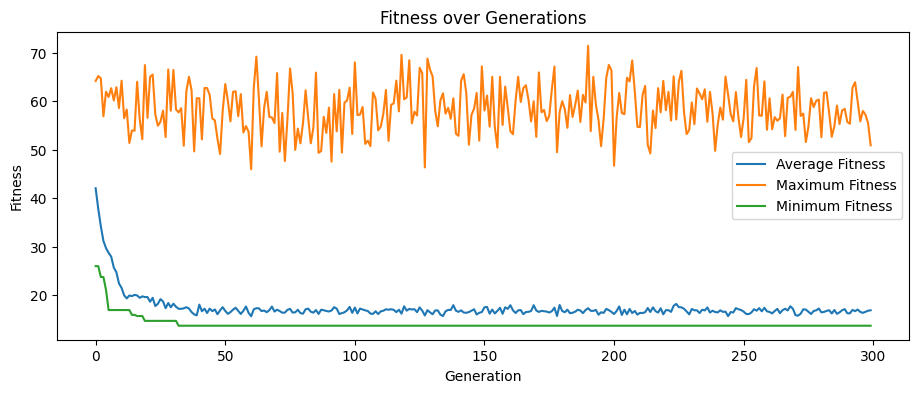

In [129]:
import matplotlib.pyplot as plt
import numpy

# Assuming you have these already defined
# toolbox, create_chromosome, etc.

# Initialize population
pop = toolbox.population(n=300)

# Evaluate the initial population
fitnesses = [toolbox.evaluate(ind) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Prepare the statistics object
logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

# Number of generations
NGEN = 300#50#100
CXPB = 0.2
MUTPB = 0.2#0.2 - 0.5 did wose on avg fitness but still produced best result - most solutions arent good - but didnt check diversity

for gen in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Update the statistics with the new population
    record = stats.compile(pop)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)

    print(logbook.stream)

    #print best individual per generation
    indv = tools.selBest(pop, 1)[0]
    print(indv)

# Extract statistics
gen = logbook.select("gen")
avg_fit = logbook.select("avg")
max_fit = logbook.select("max")
min_fit = logbook.select("min")

# Plotting
plt.figure(figsize=(11,4))
plt.plot(gen, avg_fit, label="Average Fitness")
plt.plot(gen, max_fit, label="Maximum Fitness")
plt.plot(gen, min_fit, label="Minimum Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="best")
plt.title("Fitness over Generations")
plt.show()


In [130]:
indv = tools.selBest(pop, 1)[0]
print(indv)
print(indv[:NUM_TASKS])
print(indv[NUM_TASKS:])
print(indv.fitness.values)

[3, 6, 5, 7, 0, 1, 2, 9, 8, 4, 2, 3, 2, 3, 1, 1, 1, 3, 3, 2]
[3, 6, 5, 7, 0, 1, 2, 9, 8, 4]
[2, 3, 2, 3, 1, 1, 1, 3, 3, 2]
(13.650281539872886,)


In [131]:
tasks = indv[:NUM_TASKS]
robots = indv[NUM_TASKS:]




def sub1(n):
    return n-1

robots = list(map(sub1, robots))
print(robots)
task_pos = TASK_POS#index of task_pos item maps to task number in tasks list
robot_pos =ROBOT_POS #index of robot_pos item maps to robot number in robots list


[1, 2, 1, 2, 0, 0, 0, 2, 2, 1]


In [132]:
print(set(robots))
pairs = list(zip(tasks, robots))
print(pairs)

task_pos_pairs = list(zip(tasks, task_pos))
robot_pos_pairs = list(zip(robots, robot_pos))

print(task_pos_pairs)
print(robot_pos_pairs)
assignments = []
for robot_index in set(robots):
    robot_tasks = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_tasks)
    assignments.append(robot_tasks)
print(assignments)

{0, 1, 2}
[(3, 1), (6, 2), (5, 1), (7, 2), (0, 0), (1, 0), (2, 0), (9, 2), (8, 2), (4, 1)]
[(3, [1, 1]), (6, [1, 2]), (5, [0, 1]), (7, [3, 2]), (0, [3, 4]), (1, [3, 3]), (2, [7, 6]), (9, [8, 6]), (8, [7, 8]), (4, [8, 8])]
[(1, [1, 0]), (2, [3, 0]), (1, [7, 4])]
[0, 1, 2]
[3, 5, 4]
[6, 7, 9, 8]
[[0, 1, 2], [3, 5, 4], [6, 7, 9, 8]]


In [133]:
import numpy as np

def heuristic(a, b):
    """Calculate the Manhattan distance between two points."""
    return abs(b[0] - a[0]) + abs(b[1] - a[1])

def a_star(start, goal, grid):
    """A simple A* algorithm implementation."""
    # For simplicity, this function assumes an open grid without obstacles.
    # In a more complex scenario, you would check for obstacles in the grid.

    open_set = set()
    open_set.add(tuple(start))
    came_from = {}

    g_score = {tuple(start): 0}
    f_score = {tuple(start): heuristic(start, goal)}

    while open_set:
        current = min(open_set, key=lambda x: f_score.get(x, np.inf))
        if current == tuple(goal):
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]  # Return reversed path

        open_set.remove(current)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4-directional movement
            neighbor = (current[0] + dx, current[1] + dy)
            tentative_g_score = g_score[current] + 1
            if tentative_g_score < g_score.get(neighbor, np.inf):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                open_set.add(neighbor)

    return []


[0, 1, 2]
start
[1, 0]
end
[3, 4]
end
[3, 3]
end
[7, 6]
[3, 5, 4]
start
[3, 0]
end
[1, 1]
end
[0, 1]
end
[8, 8]
[6, 7, 9, 8]
start
[7, 4]
end
[1, 2]
end
[3, 2]
end
[8, 6]
end
[7, 8]


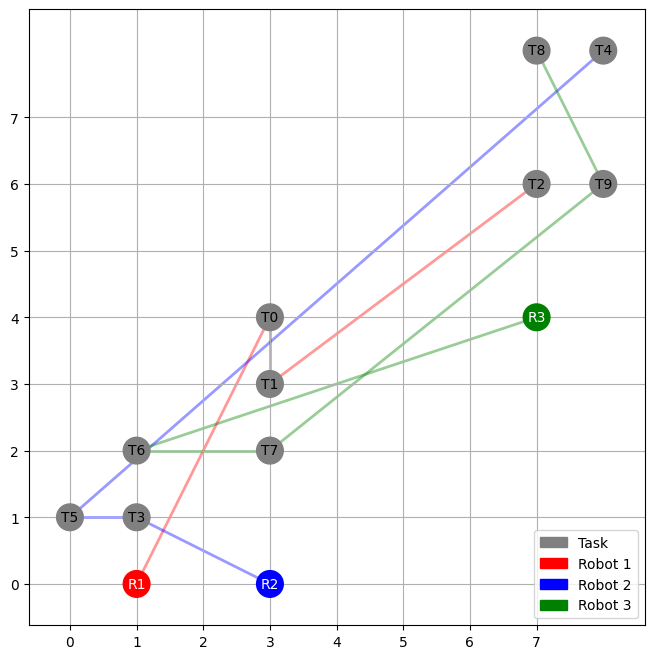

In [134]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define grid and positions
grid_size = (8, 8)  # Define the grid size
robot_colors = ['red', 'blue', 'green']

# Placeholder function for A*; replace with actual A* function
def a_star(start, goal):
    # This function should return a list of (x, y) tuples as the path from 'start' to 'goal'
    # Here it returns a direct line for illustration
    return [start, goal]

# Plotting setup
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Plot tasks and robots with labels
for idx, pos in enumerate(task_pos):
    ax.add_patch(patches.Circle(pos, 0.2, color='gray', zorder=2))
    ax.text(*pos, f'T{tasks[idx]}', horizontalalignment='center', verticalalignment='center', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

# Draw paths from each robot to each task in sequence
#for robot_num, color in zip(set(robots), robot_colors):
    # Extract tasks for this robot
#    task_indices = [i for i, x in enumerate(robots) if x == robot_num]
#    print("ti:")
#    print(task_indices)
#    task_sequence = [tasks[i] for i in task_indices]
#    print("ts:")
#    print(task_sequence)

task_pos_pairs = list(zip(tasks, task_pos))

for robot_index in set(robots):
    task_sequence = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(task_sequence)

    # Initial position of the robot
    #start = robot_pos[robot_num - 1]
    start = robot_pos[robot_index]
    print("start")
    print(start)

    # Draw paths for each task
    for task_num in task_sequence:
        # Destination task position
        #end = task_pos[task_num - 1]
        #end = task_pos[task_num]
        end = [pair[1] for pair in task_pos_pairs if pair[0] == task_num][0]
        print("end")
        print(end)
        # Calculate path
        path = a_star(start, end)
        # Draw the path
        xs, ys = zip(*path)
        ax.plot(xs, ys, color=robot_colors[robot_index], linewidth=2, zorder=1, alpha=0.4)
        # Update the start position to the end of the last path
        start = end

# Create a legend for tasks and robots
task_legend = patches.Patch(color='gray', label='Task')
plt.legend(handles=[task_legend] + robot_patches, loc='lower right')

plt.gca().set_aspect('equal', adjustable='box')
plt.gca()#.invert_yaxis()  # Invert the y-axis to match your coordinate system
plt.show()



0 [0, 1, 2]
start
[1, 0]
end
[1, 1]
end
[1, 2]
end
[0, 1]
1 [3, 5, 4]
start
[3, 0]
end
[3, 2]
end
[3, 3]
end
[3, 4]
2 [6, 7, 9, 8]
start
[7, 4]
end
[7, 6]
end
[8, 6]
end
[8, 8]
end
[7, 8]


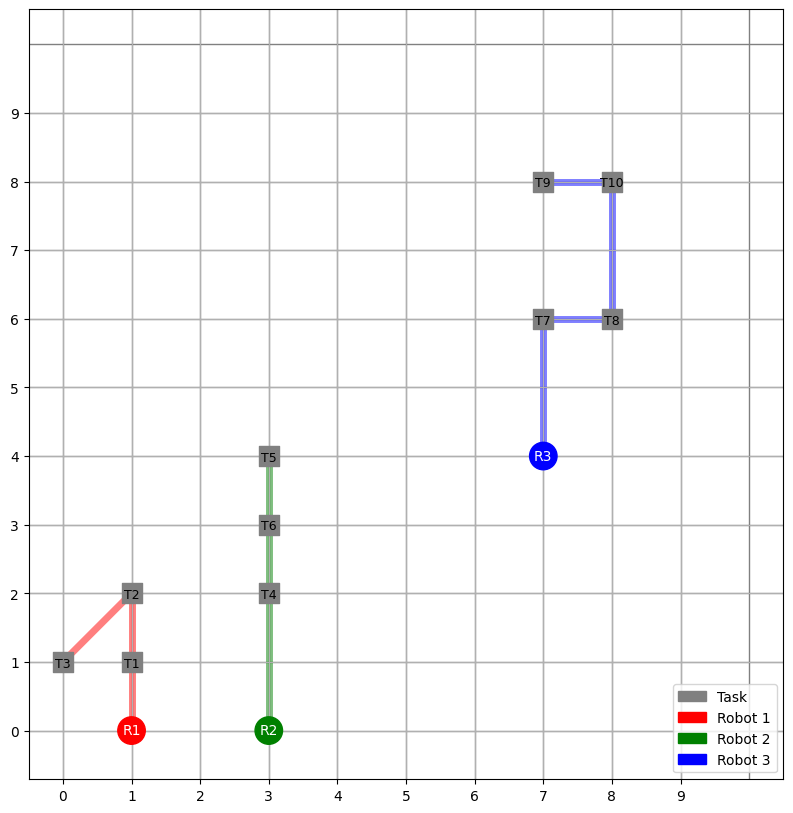

In [135]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#MAIN WORKING VIZ

# Placeholder function for A*; replace with actual A* function
def a_star(start, goal):
    # This function should return a list of (x, y) tuples as the path from 'start' to 'goal'
    # Here it returns a direct line for illustration
    return [start, goal]



# Settings
grid_size = (10, 10)
robot_colors = ['red', 'green', 'blue']
task_marker = 's'  # Square for tasks
robot_marker = 'o'  # Circle for robots
path_alpha = 0.5  # Transparency for paths

# Create figure and axes
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xlim(0, grid_size[0])
#ax.set_ylim(0, grid_size[1])

# Plotting setup
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Draw grid
for x in range(grid_size[0] + 1):
    ax.axhline(x, lw=1, color='grey', zorder=0)
    ax.axvline(x, lw=1, color='grey', zorder=0)

# Plot tasks with labels
for i, pos in enumerate(task_pos):
    ax.scatter(pos[0], pos[1], c='grey', s=200, marker=task_marker, label='Task' if i == 0 else "", zorder=2)
    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='center', va='center_baseline', zorder=3)

#better plotting:
#for idx, pos in enumerate(task_pos):
#    ax.add_patch(patches.Circle(pos, 0.2, color='gray', zorder=2))
#    ax.text(*pos, f'T{tasks[idx]}', horizontalalignment='center', verticalalignment='center', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

"""
# Plotting setup
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Plot tasks and robots with labels
for idx, pos in enumerate(task_pos):
    ax.add_patch(patches.Circle(pos, 0.2, color='gray', zorder=2))
    ax.text(*pos, f'T{tasks[idx]}', horizontalalignment='center', verticalalignment='center', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

"""



# Draw paths from each robot to each task in sequence
#for robot_num, color in zip(set(robots), robot_colors):
    # Extract tasks for this robot
#    task_indices = [i for i, x in enumerate(robots) if x == robot_num]
#    print("ti:")
#    print(task_indices)
#    task_sequence = [tasks[i] for i in task_indices]
#    print("ts:")
#    print(task_sequence)

task_pos_pairs = list(zip(tasks, task_pos))

for robot_index in set(robots):
    task_sequence = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_index, task_sequence)

    # Initial position of the robot
    #start = robot_pos[robot_num - 1]
    start = robot_pos[robot_index]
    print("start")
    print(start)

    # Draw paths for each task
    for task_num in task_sequence:
        # Destination task position
        #end = task_pos[task_num - 1]
        #end = task_pos[task_num]
        end = task_pos[task_num] #[pair[1] for pair in task_pos_pairs if pair[0] == task_num][0]
        print("end")
        print(end)
        # Calculate path
        path = a_star(start, end)
        # Draw the path
        xs, ys = zip(*path)
        ax.plot(xs, ys, color=robot_colors[robot_index], linewidth=5, zorder=1, alpha=0.5)
        # Update the start position to the end of the last path
        start = end

# Create a legend for tasks and robots
task_legend = patches.Patch(color='gray', label='Task')
plt.legend(handles=[task_legend] + robot_patches, loc='lower right')

plt.gca().set_aspect('equal', adjustable='box')
plt.gca()#.invert_yaxis()  # Invert the y-axis to match your coordinate system
plt.show()



In [136]:
print(set(robots))
pairs = list(zip(tasks, robots))
print(pairs)

for task in tasks:
    print("a")
    print(task, task_pos[task])

robot_pos_pairs = list(zip(robots, robot_pos))

print(task_pos_pairs)
print(robot_pos_pairs)
assignments = []
for robot_index in set(robots):
    robot_tasks = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_tasks)
    assignments.append(robot_tasks)
print(assignments)

n = 0
print(task_pos_pairs[n][1])

{0, 1, 2}
[(3, 1), (6, 2), (5, 1), (7, 2), (0, 0), (1, 0), (2, 0), (9, 2), (8, 2), (4, 1)]
a
3 [3, 2]
a
6 [7, 6]
a
5 [3, 3]
a
7 [8, 6]
a
0 [1, 1]
a
1 [1, 2]
a
2 [0, 1]
a
9 [8, 8]
a
8 [7, 8]
a
4 [3, 4]
[(3, [1, 1]), (6, [1, 2]), (5, [0, 1]), (7, [3, 2]), (0, [3, 4]), (1, [3, 3]), (2, [7, 6]), (9, [8, 6]), (8, [7, 8]), (4, [8, 8])]
[(1, [1, 0]), (2, [3, 0]), (1, [7, 4])]
[0, 1, 2]
[3, 5, 4]
[6, 7, 9, 8]
[[0, 1, 2], [3, 5, 4], [6, 7, 9, 8]]
[1, 1]


0 [0, 1, 2]
1 [3, 5, 4]
2 [6, 7, 9, 8]


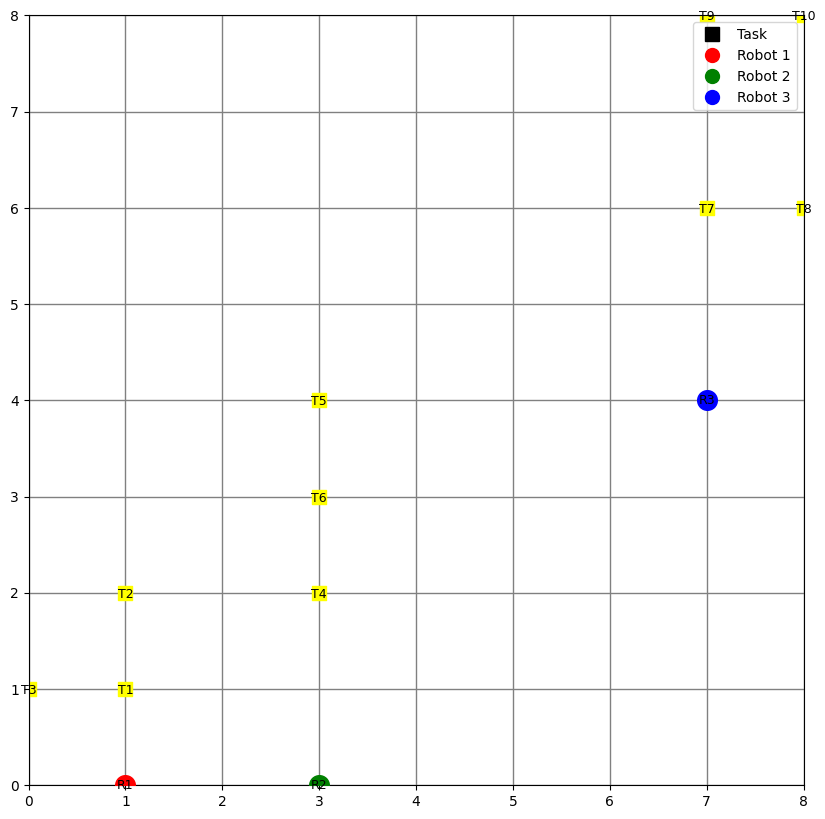

In [137]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np



# Settings
grid_size = (8, 8)
robot_colors = ['red', 'green', 'blue']
task_marker = 's'  # Square for tasks
robot_marker = 'o'  # Circle for robots
path_alpha = 0.4  # Transparency for paths

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, grid_size[0])
ax.set_ylim(0, grid_size[1])

# Draw grid
for x in range(grid_size[0] + 1):
    ax.axhline(x, lw=1, color='grey', zorder=0)
    ax.axvline(x, lw=1, color='grey', zorder=0)

# Plot tasks with labels
for i, pos in enumerate(task_pos):
    ax.scatter(pos[0], pos[1], c='yellow', s=100, marker=task_marker, label='Task' if i == 0 else "", zorder=2)
    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='center', va='center_baseline', zorder=3)
# Plot and label tasks
#for i, pos in enumerate(task_pos):
#    ax.plot(pos[0], pos[1], 'ko', zorder=5)  # Task positions as black dots
#    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='right')


# Plot and label robots initially
for i, pos in enumerate(robot_pos):
    ax.scatter(pos[0], pos[1], c=robot_colors[i], s=200, marker=robot_marker, label=f'Robot {i+1}', zorder=5)
    ax.text(pos[0], pos[1], f'R{i+1}', fontsize=9, ha='center', va='center', zorder=6)


for robot_index in set(robots):
    robot_tasks = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_index, robot_tasks)
    #start_pos = robot_pos[robot_index]
    #for task_index in robot_tasks:
    #    goal_pos = task_pos[tasks[task_index] - 1]
    #    path = a_star(start_pos, goal_pos, None)  # Assuming grid is not used in placeholder a_star
    #    xs, ys = zip(*path)
    #    ax.plot(xs, ys, c=robot_colors[robot_index], linewidth=2, alpha=path_alpha, zorder=4)
     #   start_pos = goal_pos  # Next start is the current goal

# Create custom legends
task_legend = mlines.Line2D([], [], color='black', marker=task_marker, linestyle='None', markersize=10, label='Task')
robot_legends = [mlines.Line2D([], [], color=color, marker=robot_marker, linestyle='None', markersize=10, label=f'Robot {i+1}') for i, color in enumerate(robot_colors)]
ax.legend(handles=[task_legend] + robot_legends)

plt.gca()#.invert_yaxis()  # Match grid coordinates if necessary
plt.show()